In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import spearmanr
import xgboost as xgb
from scipy.interpolate import interp1d

### Import data

In [3]:
training=pd.read_csv('train.csv')

In [4]:
training_update=pd.read_csv('train_updates_20220929.csv')

In [5]:
training.shape

(31390, 5)

In [6]:
training.head(3)

seq_id                                   protein_sequence   pH  \
0       0  AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1       1  AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2       2  AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   

                         data_source    tm  
0  doi.org/10.1038/s41592-020-0801-4  75.7  
1  doi.org/10.1038/s41592-020-0801-4  50.5  
2  doi.org/10.1038/s41592-020-0801-4  40.5

### Data cleaning

In [7]:
for row in training_update['seq_id']:
    index=training[training['seq_id']==row].index
    training.drop(index=index,inplace=True)

In [8]:
training.shape

(28956, 5)

In [9]:
training.sort_values('tm',ascending=False,inplace=True)
training.reset_index(inplace = True)
training.drop(['index','data_source'],axis=1,inplace=True)

### Feature engineering

alanine - ala - A (gif, interactive)
arginine - arg - R (gif, interactive)
asparagine - asn - N (gif, interactive)
aspartic acid - asp - D (gif, interactive)
cysteine - cys - C (gif, interactive)
glutamine - gln - Q (gif, interactive)
glutamic acid - glu - E (gif, interactive)
glycine - gly - G (gif, interactive)
histidine - his - H (gif, interactive)
isoleucine - ile - I (gif, interactive)
leucine - leu - L (gif, interactive)
lysine - lys - K (gif, interactive)
methionine - met - M (gif, interactive)
phenylalanine - phe - F (gif, interactive)
proline - pro - P (gif, interactive)
serine - ser - S (gif, interactive)
threonine - thr - T (gif, interactive)
tryptophan - trp - W (gif, interactive)
tyrosine - tyr - Y (gif, interactive)
valine - val - V (gif, interactive)

In [10]:
Amino_list=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']

In [11]:
training['length']=training['protein_sequence'].apply(len)

In [12]:
training.drop(columns = 'seq_id', inplace = True)

In [13]:
training.head(5)

protein_sequence    pH     tm  length
0  MKKFLLVAVVGLAGITFANEQLAKQKGCMACHDLKAKKVGPAFADV...  7.00  130.0      98
1  MKKFLLVAVVGLAGITFANEQLAKQKGCMACHDLKAKKVGPAFADV...  7.00  116.0      98
2  MKKYTCTVCGYIYNPEDGDPDNGVNPGTDFKDLPDDWVCPLCGVGK...  9.08  111.8      54
3  MKKYTCTVCGYIYNPEDGDPDNGINPGTDFKDIPDDWVCPLCGVGK...  9.08  109.5      54
4  MVEQDPFEIAVKQLERAAQYMDISEEALEFLKRPQRIVEVSIPVEM...  7.00  108.5     419

In [14]:
for i in range(training.shape[0]):
    if i==0:
        for j in Amino_list:
            count=training['protein_sequence'][i].count(j)
            training[j]=count
    else: 
        for j in Amino_list:
            count=training['protein_sequence'][i].count(j)
            training[j][i]=count


C:\Users\cni4\AppData\Local\Temp\ipykernel_14144\3179347969.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training[j][i]=count


In [15]:
training.head(5)

protein_sequence    pH     tm  length   A  \
0  MKKFLLVAVVGLAGITFANEQLAKQKGCMACHDLKAKKVGPAFADV...  7.00  130.0      98  15   
1  MKKFLLVAVVGLAGITFANEQLAKQKGCMACHDLKAKKVGPAFADV...  7.00  116.0      98  15   
2  MKKYTCTVCGYIYNPEDGDPDNGVNPGTDFKDLPDDWVCPLCGVGK...  9.08  111.8      54   0   
3  MKKYTCTVCGYIYNPEDGDPDNGINPGTDFKDIPDDWVCPLCGVGK...  9.08  109.5      54   0   
4  MVEQDPFEIAVKQLERAAQYMDISEEALEFLKRPQRIVEVSIPVEM...  7.00  108.5     419  41   

    R   N   D  C  Q  ...   L   K   M  F   P   S   T   W   Y   V  
0   1   2   5  2  5  ...   8  15   3  3   4   3   2   2   2   9  
1   1   2   5  2  5  ...   8  15   3  3   4   3   2   2   2   9  
2   0   3   8  4  1  ...   2   4   1  2   5   0   3   1   3   5  
3   0   3   8  4  1  ...   1   4   1  2   5   0   3   1   3   4  
4  19  16  25  2  9  ...  20  35  17  9  20  17  26  10  20  36  

[5 rows x 24 columns]

In [16]:
training.describe()

pH            tm        length             A             R  \
count  28670.000000  28956.000000  28956.000000  28956.000000  28956.000000   
mean       6.872918     51.360399    450.770928     34.479624     24.132132   
std        0.792550     12.060858    415.210465     32.305244     24.201336   
min        1.990000     25.100000      5.000000      0.000000      0.000000   
25%        7.000000     43.600000    212.000000     15.000000     10.000000   
50%        7.000000     48.800000    352.000000     27.000000     18.000000   
75%        7.000000     54.600000    537.000000     44.000000     29.000000   
max       11.000000    130.000000   8798.000000    909.000000    452.000000   

                  N             D             C             Q             E  \
count  28956.000000  28956.000000  28956.000000  28956.000000  28956.000000   
mean      19.023588     25.080640      6.603018     19.700546     32.589653   
std       19.433439     24.978429     10.118851     25.520876     35.630538   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        8.000000     11.000000      2.000000      7.000000     13.000000   
50%       14.000000     19.000000      4.000000     13.000000     24.000000   
75%       23.000000     31.000000      8.000000     23.000000     40.000000   
max      435.000000    841.000000    363.000000    773.000000    995.000000   

       ...             L             K             M             F  \
count  ...  28956.000000  28956.000000  28956.000000  28956.000000   
mean   ...     42.789888     28.001381     10.507460     16.913800   
std    ...     43.241248     28.023444      9.921487     15.334357   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...     18.000000     13.000000      5.000000      7.000000   
50%    ...     32.000000     20.000000      8.000000     13.000000   
75%    ...     51.000000     34.000000     13.000000     22.000000   
max    ...   1153.000000    745.000000    213.000000    227.000000   

                  P             S             T             W             Y  \
count  28956.000000  28956.000000  28956.000000  28956.000000  28956.000000   
mean      22.613931     32.542927     23.869975      5.007011     13.244267   
std       26.682574     37.931143     24.071397      5.623788     11.931957   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        8.000000     12.000000     11.000000      2.000000      6.000000   
50%       16.000000     22.000000     17.000000      3.000000     10.000000   
75%       27.000000     38.000000     29.000000      6.000000     17.000000   
max      772.000000    771.000000    656.000000    131.000000    199.000000   

                  V  
count  28956.000000  
mean      29.253868  
std       26.463943  
min        0.000000  
25%       14.000000  
50%       23.000000  
75%       36.000000  
max      554.000000  

[8 rows x 23 columns]

### Data exploration

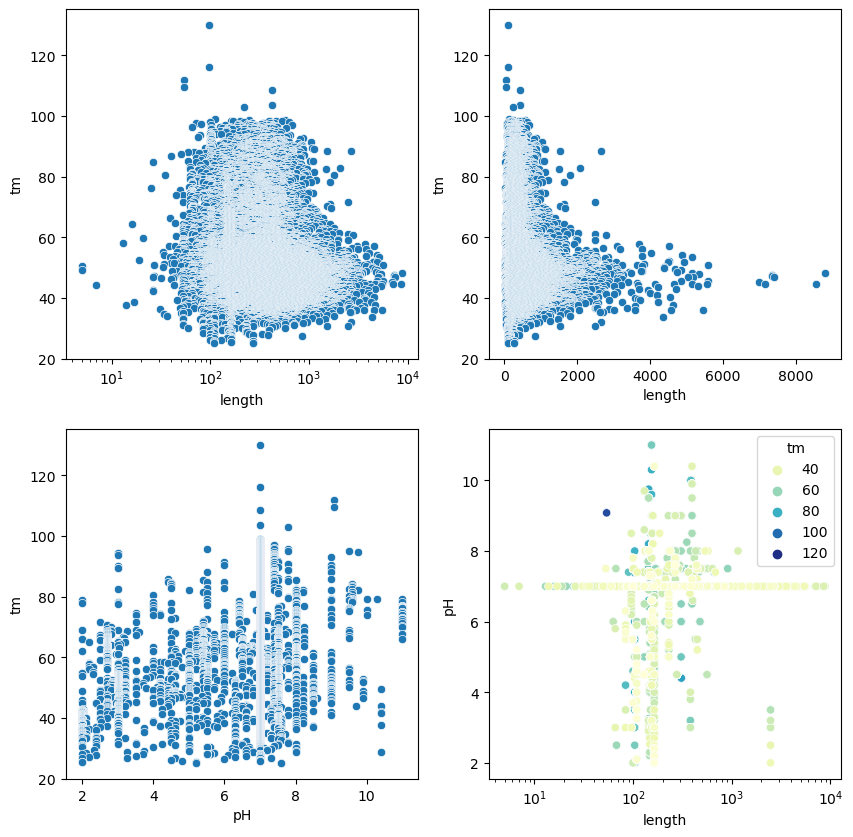

In [17]:
fig, ax= plt.subplots(2, 2, figsize= (10,10))
ax[0,0]=sns.scatterplot(x='length', y='tm', data=training,ax=ax[0,0])
ax[0,0].set(xscale="log")
ax[0,1]=sns.scatterplot(x='length', y='tm', data=training,ax=ax[0,1])

ax[1,0]=sns.scatterplot(x='pH', y='tm', data=training,ax=ax[1,0])
ax[1,1]=sns.scatterplot(x='length', y='pH', data=training, palette='YlGnBu', hue='tm',ax=ax[1,1])
ax[1,1].set(xscale="log")
plt.show()

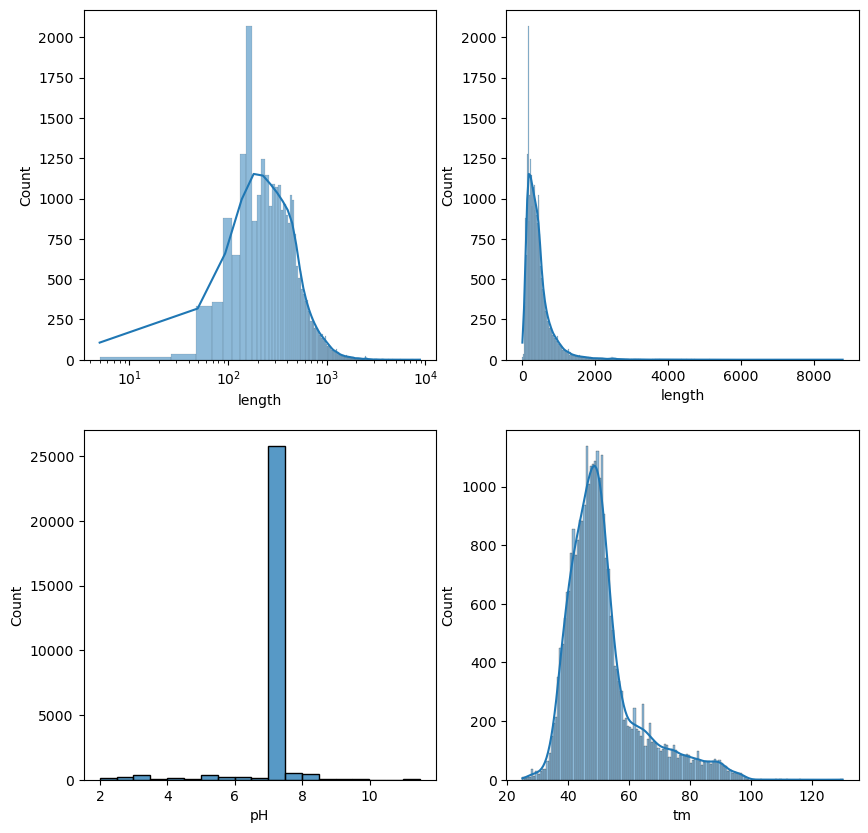

In [18]:
fig, ax= plt.subplots(2, 2, figsize= (10,10))
ax[0,0]=sns.histplot(training['length'], kde=True, ax=ax[0,0])
ax[0,0].set(xscale="log")
ax[0,1]=sns.histplot(training['length'], kde=True, ax=ax[0,1])
ax[1,0]=sns.histplot(training['pH'],binwidth=0.5, ax=ax[1,0])
ax[1,1]=sns.histplot(training['tm'], kde=True, ax=ax[1,1])

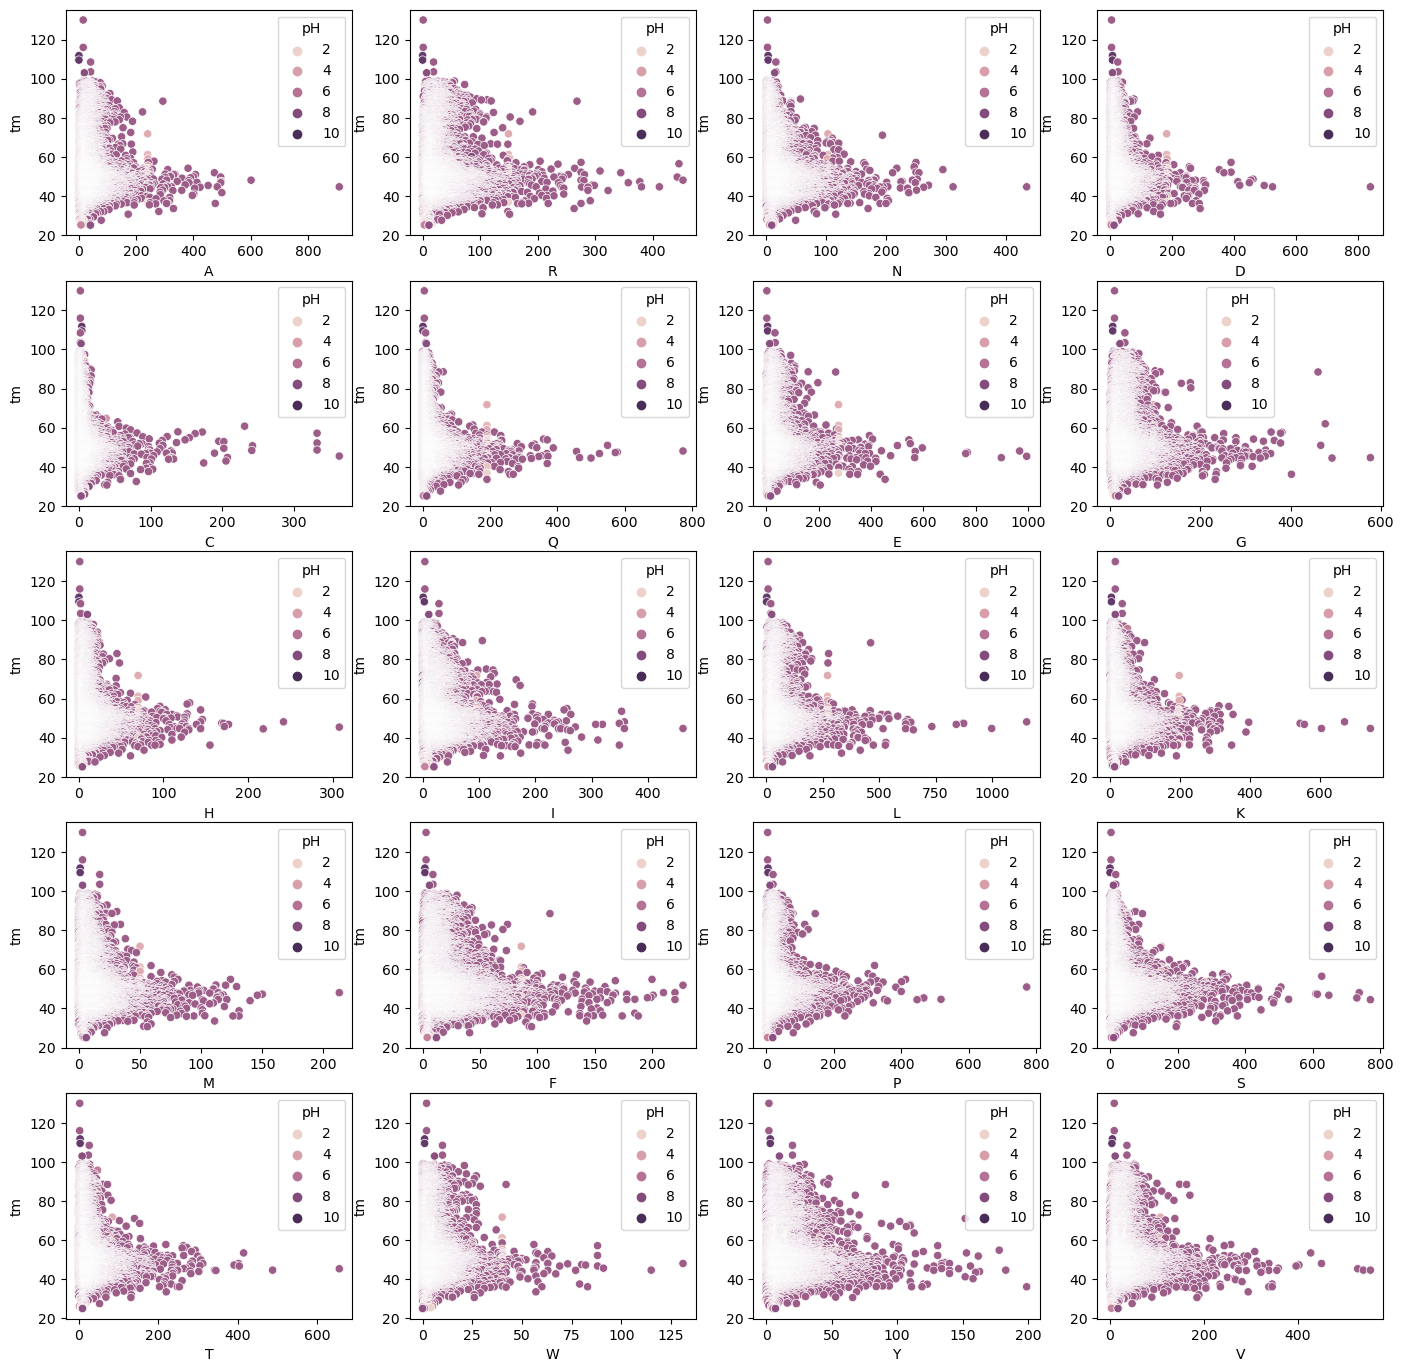

In [19]:
k=0
fig, ax = plt.subplots(5, 4, figsize= (17,17))
for i in range (0,5):
    for j in range(0,4):
        plt
        sns.scatterplot(x=Amino_list[k], y='tm', data=training, hue='pH', ax=ax[i, j])
        k=k+1

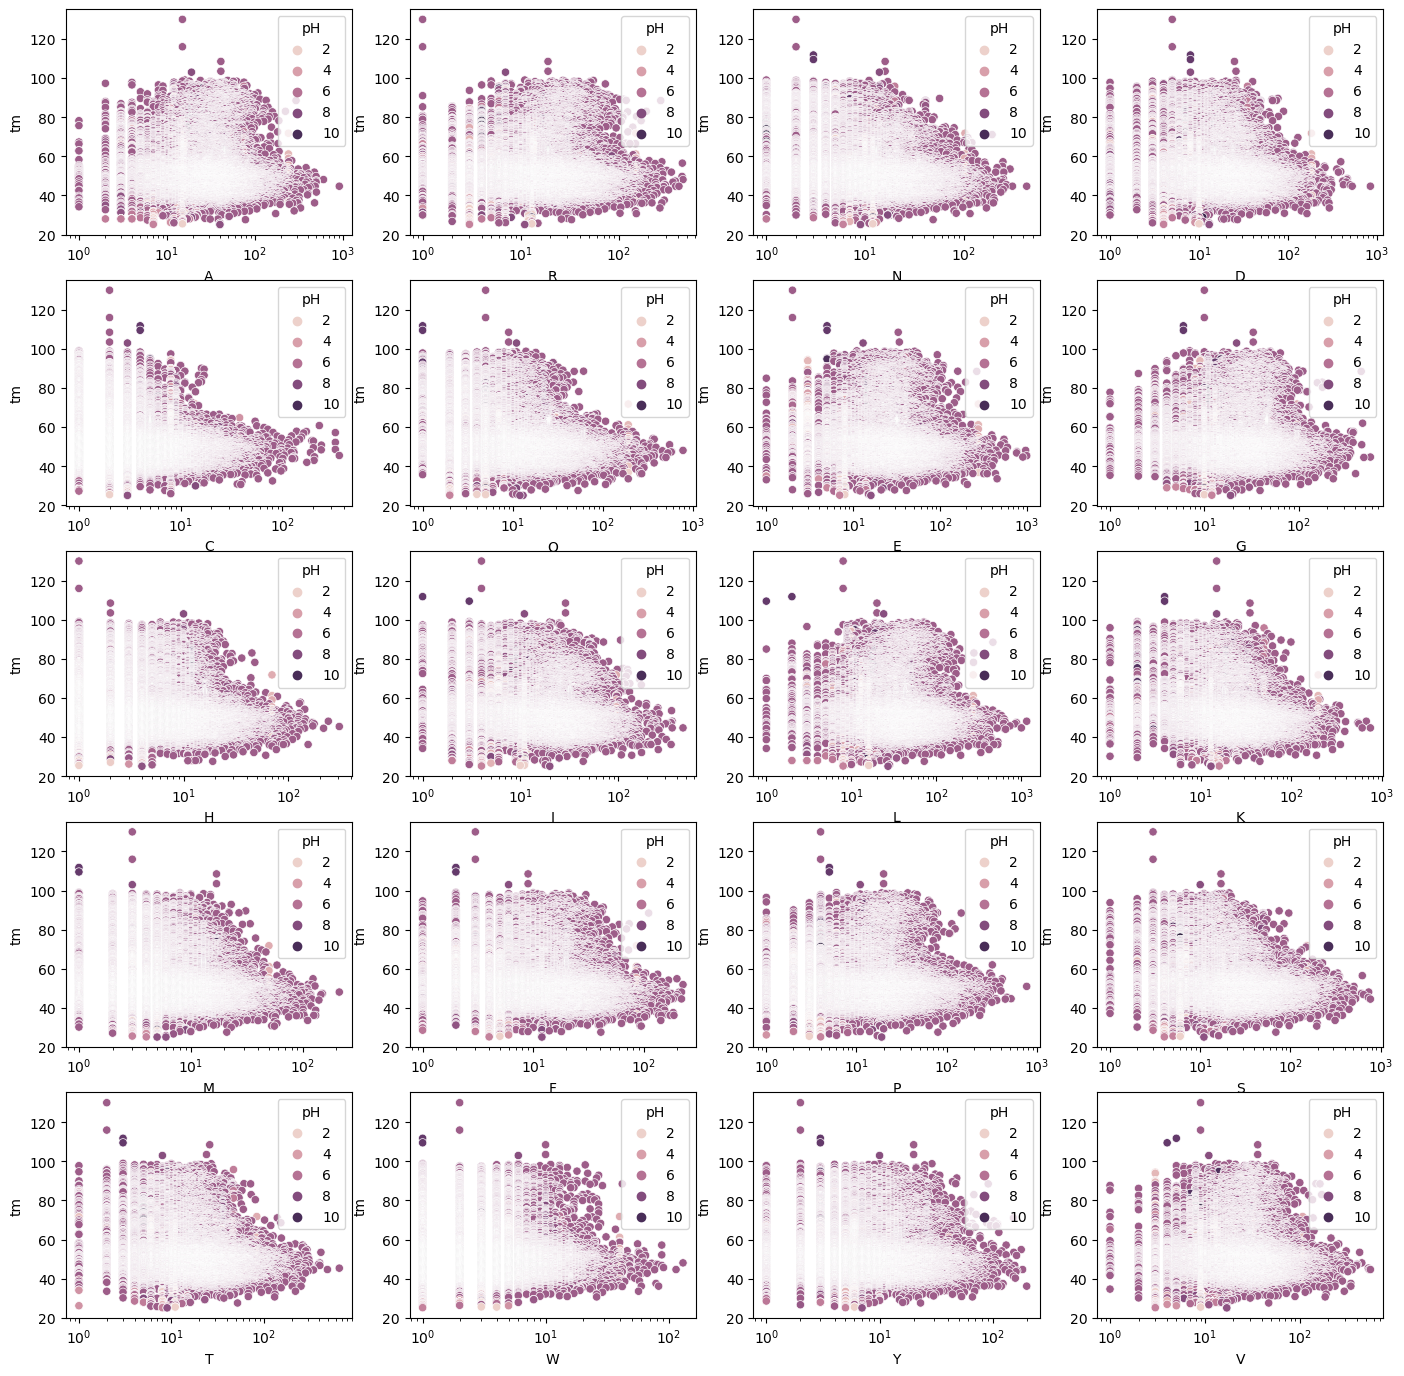

In [20]:
k=0
fig, ax = plt.subplots(5, 4, figsize= (17,17))
for i in range (0,5):
    for j in range(0,4):
        plt
        sns.scatterplot(x=Amino_list[k], y='tm', data=training, hue='pH', ax=ax[i, j])
        ax[i, j].set(xscale="log")
        k=k+1

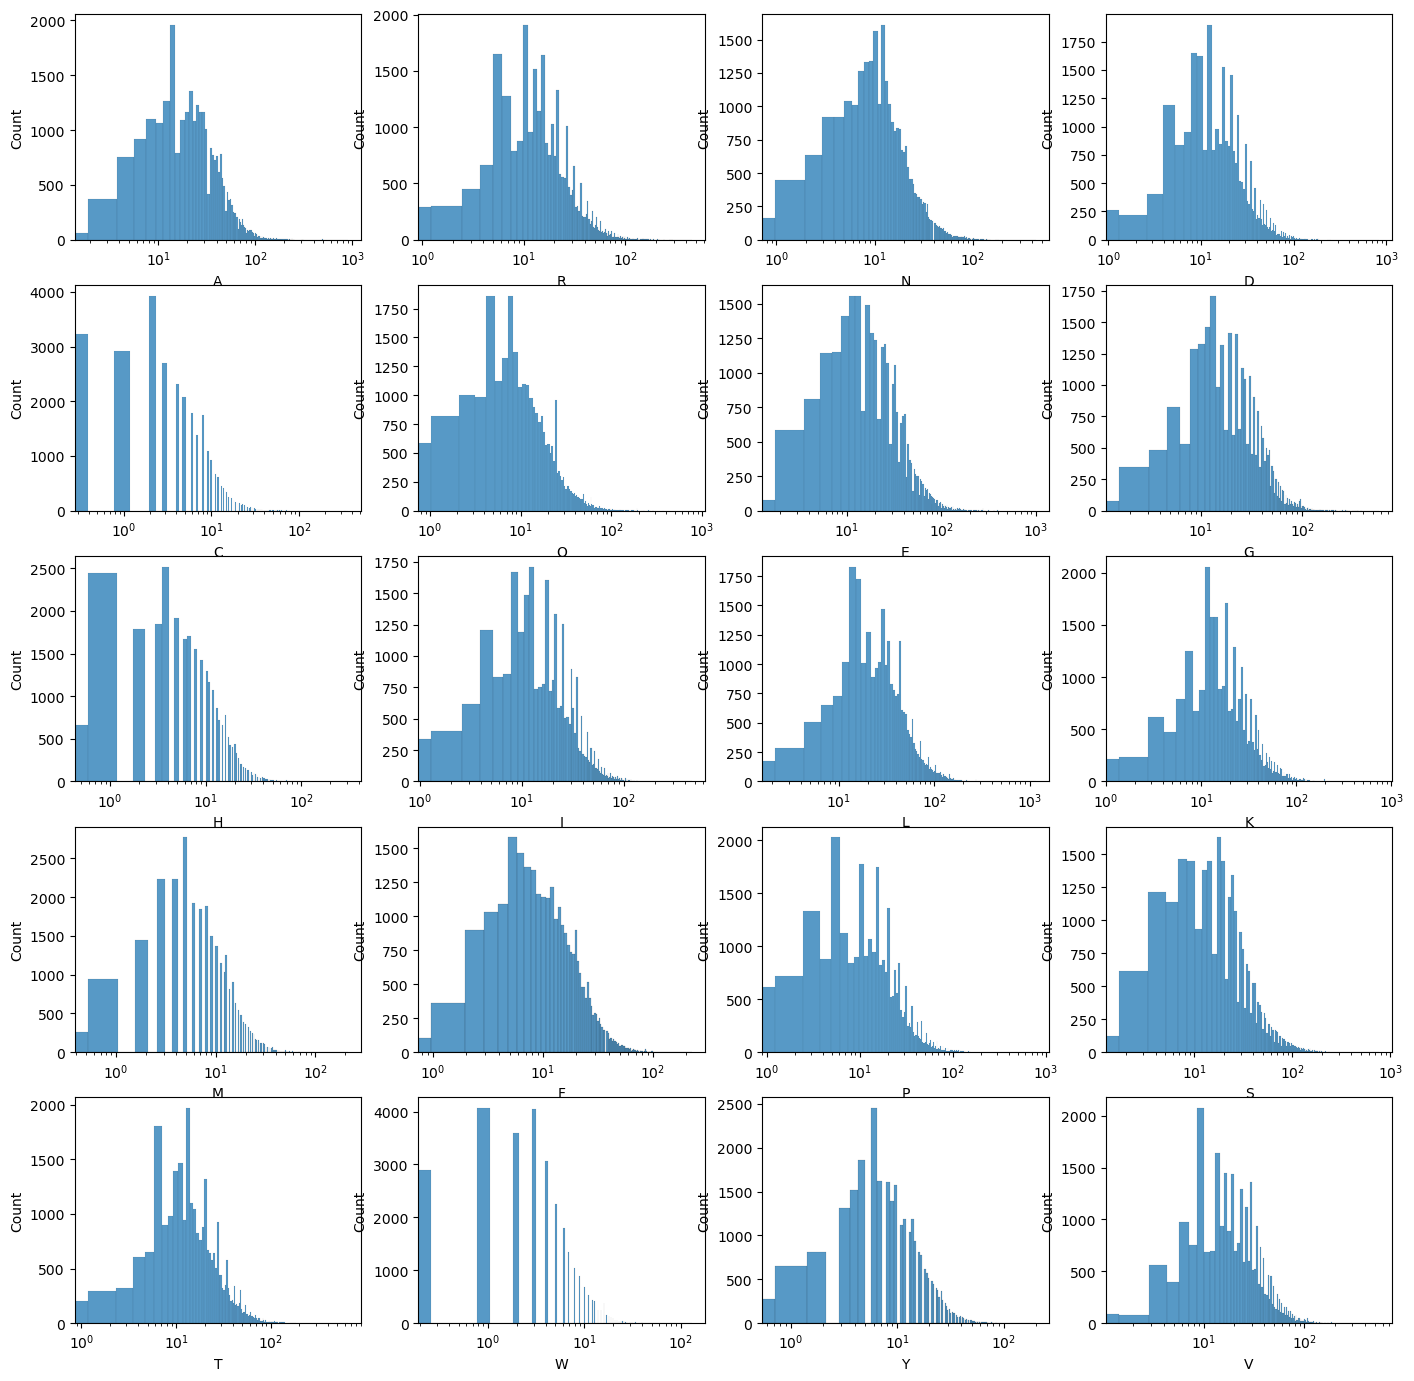

In [21]:
k=0
fig, ax = plt.subplots(5, 4, figsize= (17,17))
for i in range (0,5):
    for j in range(0,4):
        sns.histplot(training[Amino_list[k]], kde=False, ax=ax[i, j])
        ax[i, j].set(xscale="log")
        k=k+1


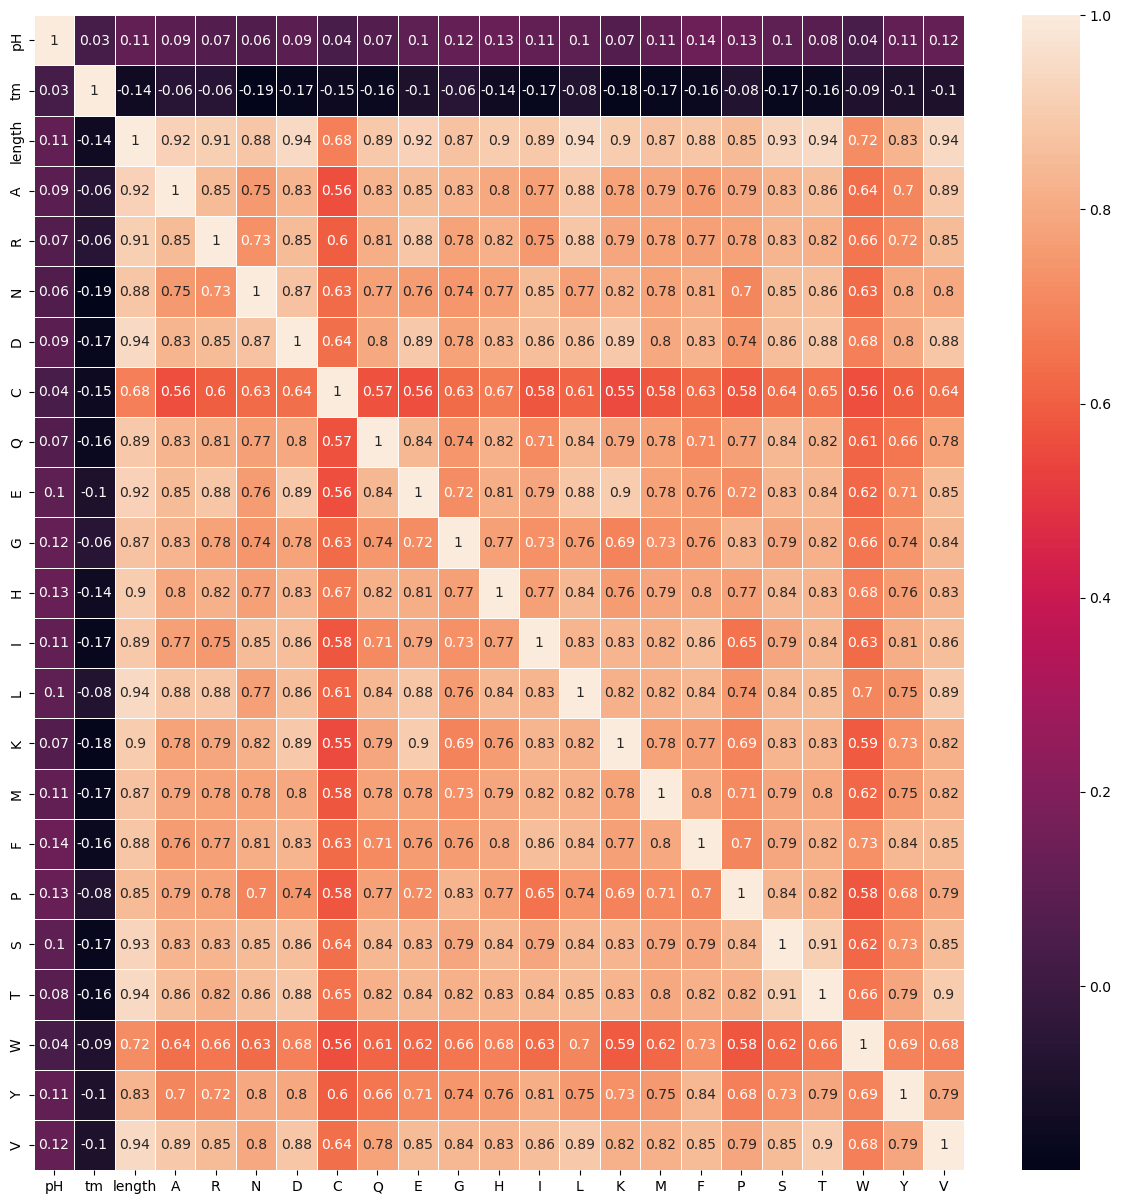

In [22]:
fig, ax= plt.subplots(1, 1, figsize= (15,15))
sns.heatmap(training.corr().round(2), annot=True,linewidths=.5)
plt.show()

In [23]:
corr=training.corr()
cols=corr['tm'].sort_values(ascending=False).index
cols[0:5]

Index(['tm', 'pH', 'G', 'R', 'A'], dtype='object')

### XG Boost model

In [25]:
train = training[training['tm']>50]

X = train.drop(columns = ['tm','protein_sequence'])
y = train['tm']

In [26]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = .2, random_state = 3)

In [27]:
model = xgb.XGBRegressor(n_estimators = 200, max_depth = 5)
model.fit(X_train, y_train)
predictions = model.predict(X_cv)

In [28]:
print('Mean Absolute Error =', mean_absolute_error(y_cv, predictions))
print('Mean Absolute Percentage Error = ', mean_absolute_percentage_error(y_cv, predictions))

Mean Absolute Error = 4.938681188964844
Mean Absolute Percentage Error =  0.07835519360550358


In [29]:
predictions_training = model.predict(X_train)
rho, p = spearmanr(y_train, predictions_training)
print('Spearman Correlation Coefficient training XG=', rho.round(3))

Spearman Correlation Coefficient training XG= 0.877


In [30]:
rho, p = spearmanr(y_cv, predictions)
print('Spearman Correlation Coefficient cross validation XG=', rho)

Spearman Correlation Coefficient cross validation XG= 0.6868152010050156


In [31]:
features = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


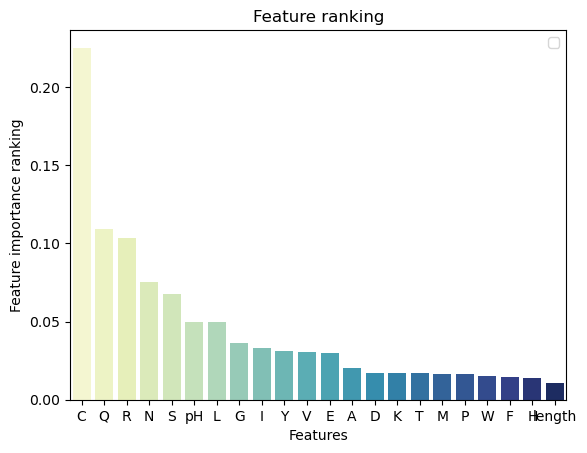

In [32]:
sns.barplot(x=features.index, y=features, palette='YlGnBu')
plt.ylabel('Feature importance ranking')
plt.xlabel('Features')
plt.title("Feature ranking")
plt.legend()
plt.show()

### Neural Network model

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

In [34]:
train_tf = training[training['tm']>50].dropna()

Xtf = train_tf.drop(columns = ['tm','protein_sequence']).to_numpy()
ytf = train_tf['tm'].to_numpy().reshape(-1,1)

In [35]:
print(f"pH Max, Min pre normalization: {np.max(Xtf[:,0]):0.2f}, {np.min(Xtf[:,0]):0.2f}")
print(f"Length    Max, Min pre normalization: {np.max(Xtf[:,1]):0.2f}, {np.min(Xtf[:,1]):0.2f}")
print(f"A    Max, Min pre normalization: {np.max(Xtf[:,2]):0.2f}, {np.min(Xtf[:,2]):0.2f}")
print(f"R    Max, Min pre normalization: {np.max(Xtf[:,3]):0.2f}, {np.min(Xtf[:,3]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(Xtf)  # learns mean, variance
Xn = norm_l(Xtf)
print(f"pH Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Length    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")
print(f"A    Max, Min post normalization: {np.max(Xn[:,2]):0.2f}, {np.min(Xn[:,2]):0.2f}")
print(f"R    Max, Min post normalization: {np.max(Xn[:,3]):0.2f}, {np.min(Xn[:,3]):0.2f}")

print(f"y=tm Max, Min pre normalization: {np.max(ytf[:]):0.2f}, {np.min(ytf[:]):0.2f}")
#norm_l_y = tf.keras.layers.Normalization(axis=-1)
#norm_l_y.adapt(ytf)  # learns mean, variance
yn=ytf
#yn = norm_l_y(ytf)
#print(f"y=tm Max, Min post normalization: {np.max(yn[:]):0.2f}, {np.min(yn[:]):0.2f}")

pH Max, Min pre normalization: 11.00, 2.00
Length    Max, Min pre normalization: 5587.00, 5.00
A    Max, Min pre normalization: 473.00, 0.00
R    Max, Min pre normalization: 445.00, 0.00
pH Max, Min post normalization: 4.59, -5.37
Length    Max, Min post normalization: 15.36, -1.11
A    Max, Min post normalization: 16.20, -1.13
R    Max, Min post normalization: 19.84, -0.99
y=tm Max, Min pre normalization: 130.00, 50.10


In [36]:
print(Xn.shape, yn.shape) 

(12409, 22) (12409, 1)


In [37]:
X_train_tf, X_cv_tf, y_train_tf, y_cv_tf = train_test_split(Xn.numpy(), yn, test_size = .2, random_state = 1)

In [38]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(22,)),
        Dense(500, activation='relu', name = 'layer1',kernel_regularizer=regularizers.l2(0.01)),
        Dense(250, activation='relu', name = 'layer2',kernel_regularizer=regularizers.l2(0.01)),
        Dense(25, activation='relu', name = 'layer3',kernel_regularizer=regularizers.l2(0.01)),
        Dense(1, activation='relu', name = 'layer4')
     ]
)

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 500)               11500     
                                                                 
 layer2 (Dense)              (None, 250)               125250    
                                                                 
 layer3 (Dense)              (None, 25)                6275      
                                                                 
 layer4 (Dense)              (None, 1)                 26        
                                                                 
Total params: 143,051
Trainable params: 143,051
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    X_train_tf,y_train_tf,            
    epochs=30,
)

Epoch 1/30
311/311 [==============================] - 1s 3ms/step - loss: 474.6889
Epoch 2/30
311/311 [==============================] - 1s 2ms/step - loss: 109.2741
Epoch 3/30
311/311 [==============================] - 1s 3ms/step - loss: 86.2521
Epoch 4/30
311/311 [==============================] - 1s 2ms/step - loss: 86.5654
Epoch 5/30
311/311 [==============================] - 1s 3ms/step - loss: 87.2440
Epoch 6/30
311/311 [==============================] - 1s 2ms/step - loss: 78.3783
Epoch 7/30
311/311 [==============================] - 1s 3ms/step - loss: 76.3191
Epoch 8/30
311/311 [==============================] - 1s 3ms/step - loss: 76.0722
Epoch 9/30
311/311 [==============================] - 1s 3ms/step - loss: 77.0383
Epoch 10/30
311/311 [==============================] - 1s 2ms/step - loss: 73.0763
Epoch 11/30
311/311 [==============================] - 1s 2ms/step - loss: 69.4503
Epoch 12/30
311/311 [==============================] - 1s 2ms/step - loss: 69.7310
Epoch 13/30

In [41]:
#W1, b1 = model.get_layer("layer1").get_weights()
#W2, b2 = model.get_layer("layer2").get_weights()
#print("W1:\n", W1, "\nb1:", b1)
#print("W2:\n", W2, "\nb2:", b2)

In [42]:
predictions_tf = model.predict(X_cv_tf)
#print("predictions = \n", predictions_tf)

78/78 [==============================] - 0s 2ms/step


In [43]:
print('Mean Absolute Error =', mean_absolute_error(y_cv_tf, predictions_tf))
print('Mean Absolute Percentage Error = ', mean_absolute_percentage_error(y_cv_tf, predictions_tf))

Mean Absolute Error = 5.068655743164751
Mean Absolute Percentage Error =  0.08215465477376394


In [44]:
predictions_training_tf = model.predict(X_train_tf)
rho, p = spearmanr(y_train_tf, predictions_training_tf)
print('Spearman Correlation Coefficient training tf=', rho.round(3))

311/311 [==============================] - 1s 2ms/step
Spearman Correlation Coefficient training tf= 0.681


In [45]:
rho, p = spearmanr(y_cv_tf, predictions_tf)
print('Spearman Correlation Coefficient cross validation tf=', rho.round(3))

Spearman Correlation Coefficient cross validation tf= 0.683


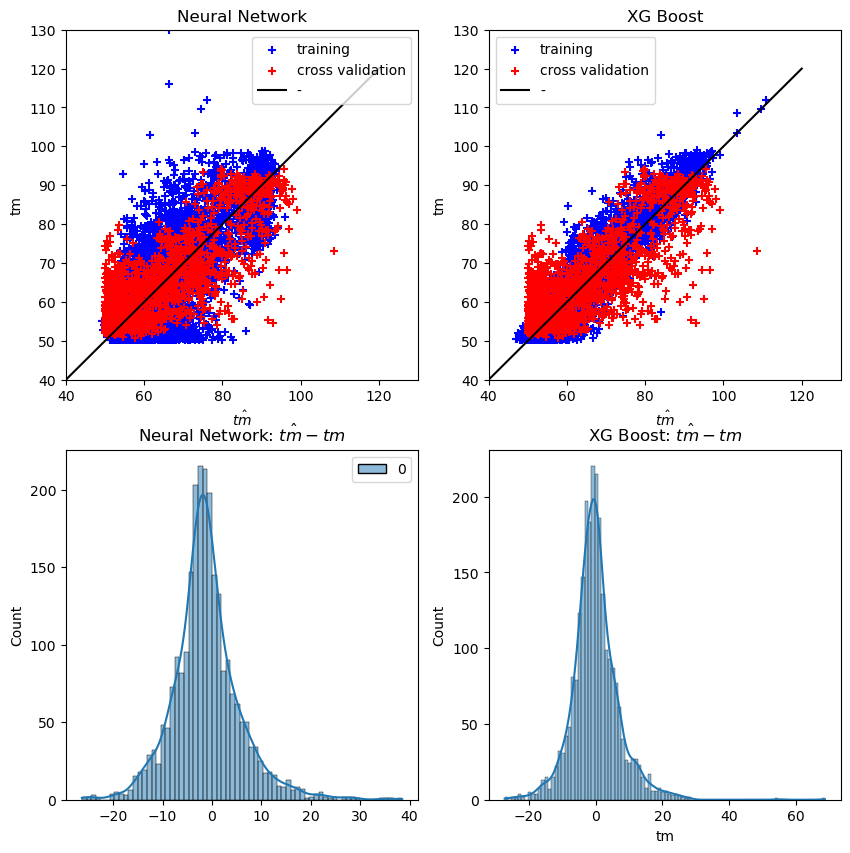

In [46]:
x=range(0,130,10)
y = x
f = interp1d(x, y)
fig, ax= plt.subplots(2, 2, figsize= (10,10))
ax[0,0].scatter(predictions_training_tf,y_train_tf, marker='+', c='b')
ax[0,0].scatter(y_cv_tf,predictions_tf, marker='+', c='r')
ax[0,0].set_xlim(40,130)
ax[0,0].set_ylim(40,130)
ax[0,0].plot(x, f(x), '-', c='black')
ax[0,0].legend(['training', 'cross validation', '-'], loc='best')
ax[0,0].set_ylabel('tm')
ax[0,0].set_xlabel(r'$\hat{tm}$')
ax[0,0].set_title('Neural Network')

ax[0,1].scatter(predictions_training,y_train, marker='+', c='b')
ax[0,1].scatter(y_cv_tf,predictions_tf, marker='+', c='r')
ax[0,1].set_xlim(40,130)
ax[0,1].set_ylim(40,130)
ax[0,1].plot(x, f(x), '-', c='black')
ax[0,1].legend(['training', 'cross validation', '-'], loc='best')
ax[0,1].set_ylabel('tm')
ax[0,1].set_xlabel(r'$\hat{tm}$')
ax[0,1].set_title('XG Boost')

#ax[1,0].hist(y_cv_tf-predictions_tf)
ax[1,0]=sns.histplot(y_cv_tf-predictions_tf, kde=True, ax=ax[1,0])
ax[1,0].set_title(r'Neural Network: $\hat{tm}-tm$')
ax[1,1]==sns.histplot(y_cv-predictions, kde=True, ax=ax[1,1])
ax[1,1].set_title(r'XG Boost: $\hat{tm}-tm$')

plt.show()



### 3D

In [52]:
from biopandas.pdb import PandasPdb
import plotly.express as px

import blosum as bl
import Levenshtein
from Levenshtein import distance as levenshtein_distance
from Bio.SubsMat import MatrixInfo
#import cudf

In [77]:
pdb_df =  PandasPdb().read_pdb('wildtype_structure_prediction_af2.pdb')
pdb_df.df.keys()

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])

In [86]:
atom_df=pdb_df.df['ATOM']
hetatm_df=pdb_df.df['HETATM']
anisou_df=pdb_df.df['ANISOU']
others_df=pdb_df.df['OTHERS']
print(f'ATOM: {atom_df.shape}')
display(atom_df.head())
print(f'HETATM: {hetatm_df.shape}')
display(hetatm_df.head())
print(f'ANISOU: {anisou_df.shape}')
display(anisou_df.head())
print(f'OTHERS: {others_df.shape}')
display(others_df.head())

ATOM: (3317, 21)


record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
0        ATOM            1                 N                  VAL           
1        ATOM            2                 H                  VAL           
2        ATOM            3                H2                  VAL           
3        ATOM            4                H3                  VAL           
4        ATOM            5                CA                  VAL           

  chain_id  residue_number insertion  ... x_coord  y_coord  z_coord  \
0        A               1            ...  34.064   -6.456   50.464   
1        A               1            ...  33.576   -6.009   51.228   
2        A               1            ...  33.882   -7.449   50.477   
3        A               1            ...  35.060   -6.323   50.566   
4        A               1            ...  33.643   -5.877   49.162   

   occupancy  b_factor  blank_4 segment_id element_symbol charge  line_idx  
0        1.0     45.11                                  N    NaN         0  
1        1.0     45.11                                  H    NaN         1  
2        1.0     45.11                                  H    NaN         2  
3        1.0     45.11                                  H    NaN         3  
4        1.0     45.11                                  C    NaN         4  

[5 rows x 21 columns]

HETATM: (0, 21)


Empty DataFrame
Columns: [record_name, atom_number, blank_1, atom_name, alt_loc, residue_name, blank_2, chain_id, residue_number, insertion, blank_3, x_coord, y_coord, z_coord, occupancy, b_factor, blank_4, segment_id, element_symbol, charge, line_idx]
Index: []

[0 rows x 21 columns]

ANISOU: (0, 21)


Empty DataFrame
Columns: [record_name, atom_number, blank_1, atom_name, alt_loc, residue_name, blank_2, chain_id, residue_number, insertion, blank_3, U(1,1), U(2,2), U(3,3), U(1,2), U(1,3), U(2,3), blank_4, element_symbol, charge, line_idx]
Index: []

[0 rows x 21 columns]

OTHERS: (2, 3)


record_name                 entry  line_idx
0         TER   3318      LYS A 221      3317
1         END                            3318

In [93]:
fig = px.scatter_3d(atom_df, x = "x_coord",
                    y = "y_coord",
                    z = "z_coord",
                    color = "element_symbol",
                    color_discrete_sequence = ["#84FFA9", "#00FFF7", "#003AFF", "#F000FF", "#FBFF00"])
#fig.update_traces(marker = dict(size = 3))
#fig.update_coloraxes(showscale = False)
fig.show()

In [94]:
mapNumberToB = atom_df.groupby('residue_number').b_factor.mean()

In [95]:
mapNumberToB

residue_number
1      45.11
2      41.54
3      40.19
4      42.11
5      42.39
       ...  
217    98.01
218    98.06
219    97.74
220    96.13
221    93.80
Name: b_factor, Length: 221, dtype: float64

In [96]:
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

In [101]:
listOutput=[]
for i in range(len(training)):
    rowProteinSequence = training.iloc[i].protein_sequence ## Taking a row
    LevenstreinDist = Levenshtein.editops(rowProteinSequence, base) ## Using Levenshtein
    listOutput.append(LevenstreinDist)

In [112]:
listOutput[1:3]

[[('insert', 0, 0),
  ('replace', 0, 1),
  ('replace', 1, 2),
  ('replace', 2, 3),
  ('replace', 3, 4),
  ('replace', 4, 5),
  ('replace', 5, 6),
  ('replace', 6, 7),
  ('insert', 8, 9),
  ('insert', 8, 10),
  ('insert', 9, 12),
  ('insert', 9, 13),
  ('replace', 10, 15),
  ('insert', 12, 17),
  ('replace', 12, 18),
  ('insert', 14, 20),
  ('insert', 14, 21),
  ('insert', 14, 22),
  ('insert', 14, 23),
  ('insert', 14, 24),
  ('insert', 14, 25),
  ('insert', 14, 26),
  ('insert', 14, 27),
  ('replace', 15, 29),
  ('replace', 16, 30),
  ('replace', 17, 31),
  ('replace', 18, 32),
  ('insert', 20, 34),
  ('insert', 20, 35),
  ('insert', 20, 36),
  ('insert', 21, 38),
  ('insert', 21, 39),
  ('replace', 22, 41),
  ('replace', 23, 42),
  ('replace', 24, 43),
  ('replace', 25, 44),
  ('replace', 26, 45),
  ('replace', 28, 47),
  ('insert', 30, 49),
  ('insert', 30, 50),
  ('insert', 31, 52),
  ('insert', 31, 53),
  ('insert', 31, 54),
  ('insert', 31, 55),
  ('replace', 31, 56),
  ('replace

### Test

In [119]:
test=pd.read_csv('test.csv')

In [120]:
test.shape

(2413, 4)

In [121]:
test.head(3)

seq_id                                   protein_sequence  pH data_source
0   31390  VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes
1   31391  VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes
2   31392  VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...   8   Novozymes

In [123]:
test.drop(['data_source'],axis=1,inplace=True)

In [124]:
test.head(3)

seq_id                                   protein_sequence  pH
0   31390  VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8
1   31391  VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8
2   31392  VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...   8

In [125]:
test['length']=test['protein_sequence'].apply(len)

In [126]:
for i in range(test.shape[0]):
    if i==0:
        for j in Amino_list:
            count=test['protein_sequence'][i].count(j)
            test[j]=count
    else: 
        for j in Amino_list:
            count=test['protein_sequence'][i].count(j)
            test[j][i]=count


C:\Users\cni4\AppData\Local\Temp\ipykernel_14144\2535323555.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [127]:
test.head(3)

seq_id                                   protein_sequence  pH  length   A  \
0   31390  VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8     221  22   
1   31391  VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8     221  22   
2   31392  VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...   8     220  22   

   R   N   D  C   Q  ...   L   K  M   F   P   S  T  W  Y   V  
0  3  19  15  4  13  ...  10  24  0  10  17  18  8  6  6  13  
1  3  19  15  4  13  ...  10  25  0  10  17  18  8  6  6  13  
2  3  19  15  4  13  ...  10  24  0  10  17  18  8  6  6  13  

[3 rows x 24 columns]

In [129]:
test.describe()

seq_id      pH       length            A            R  \
count   2413.000000  2413.0  2413.000000  2413.000000  2413.000000   
mean   32596.000000     8.0   220.968090    21.949441     3.024865   
std      696.717422     0.0     0.175798     0.377559     0.241358   
min    31390.000000     8.0   220.000000    21.000000     2.000000   
25%    31993.000000     8.0   221.000000    22.000000     3.000000   
50%    32596.000000     8.0   221.000000    22.000000     3.000000   
75%    33199.000000     8.0   221.000000    22.000000     3.000000   
max    33802.000000     8.0   221.000000    23.000000     4.000000   

                 N            D            C            Q            E  ...  \
count  2413.000000  2413.000000  2413.000000  2413.000000  2413.000000  ...   
mean     18.957729    14.988396     4.053875    12.964774     7.026523  ...   
std       0.369712     0.319148     0.225817     0.346749     0.280888  ...   
min      18.000000    14.000000     4.000000    12.000000     6.000000  ...   
25%      19.000000    15.000000     4.000000    13.000000     7.000000  ...   
50%      19.000000    15.000000     4.000000    13.000000     7.000000  ...   
75%      19.000000    15.000000     4.000000    13.000000     7.000000  ...   
max      20.000000    16.000000     5.000000    14.000000     8.000000  ...   

                 L            K            M            F            P  \
count  2413.000000  2413.000000  2413.000000  2413.000000  2413.000000   
mean     10.995027    23.912971     0.050974    10.018649    16.980937   
std       0.315401     0.396776     0.219990     0.299364     0.345021   
min      10.000000    23.000000     0.000000     9.000000    16.000000   
25%      11.000000    24.000000     0.000000    10.000000    17.000000   
50%      11.000000    24.000000     0.000000    10.000000    17.000000   
75%      11.000000    24.000000     0.000000    10.000000    17.000000   
max      12.000000    25.000000     1.000000    11.000000    18.000000   

                 S            T            W            Y            V  
count  2413.000000  2413.000000  2413.000000  2413.000000  2413.000000  
mean     17.953585     8.016162     6.027766     6.023208    13.006631  
std       0.374787     0.286780     0.267923     0.279703     0.308727  
min      17.000000     7.000000     5.000000     5.000000    12.000000  
25%      18.000000     8.000000     6.000000     6.000000    13.000000  
50%      18.000000     8.000000     6.000000     6.000000    13.000000  
75%      18.000000     8.000000     6.000000     6.000000    13.000000  
max      19.000000     9.000000     7.000000     7.000000    14.000000  

[8 rows x 23 columns]

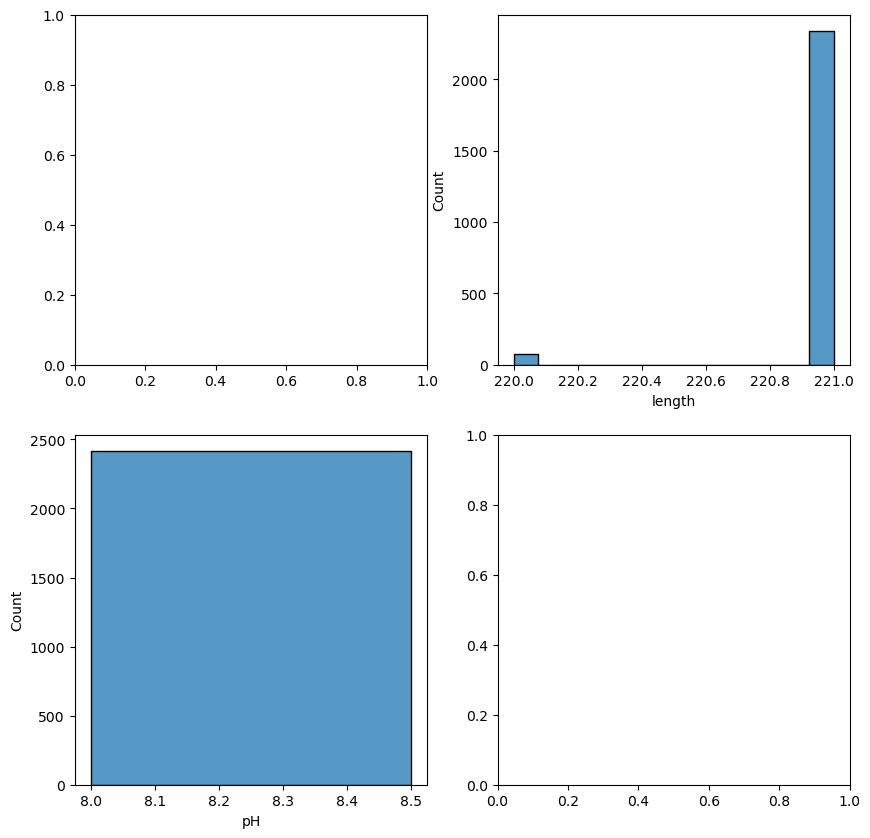

In [132]:
fig, ax= plt.subplots(2, 2, figsize= (10,10))
#ax[0,0]=sns.histplot(test['length'], ax=ax[0,0])
#ax[0,0].set(xscale="log")
ax[0,1]=sns.histplot(test['length'], ax=ax[0,1])
ax[1,0]=sns.histplot(test['pH'],binwidth=0.5, ax=ax[1,0])
#ax[1,1]=sns.histplot(training['tm'], kde=True, ax=ax[1,1])

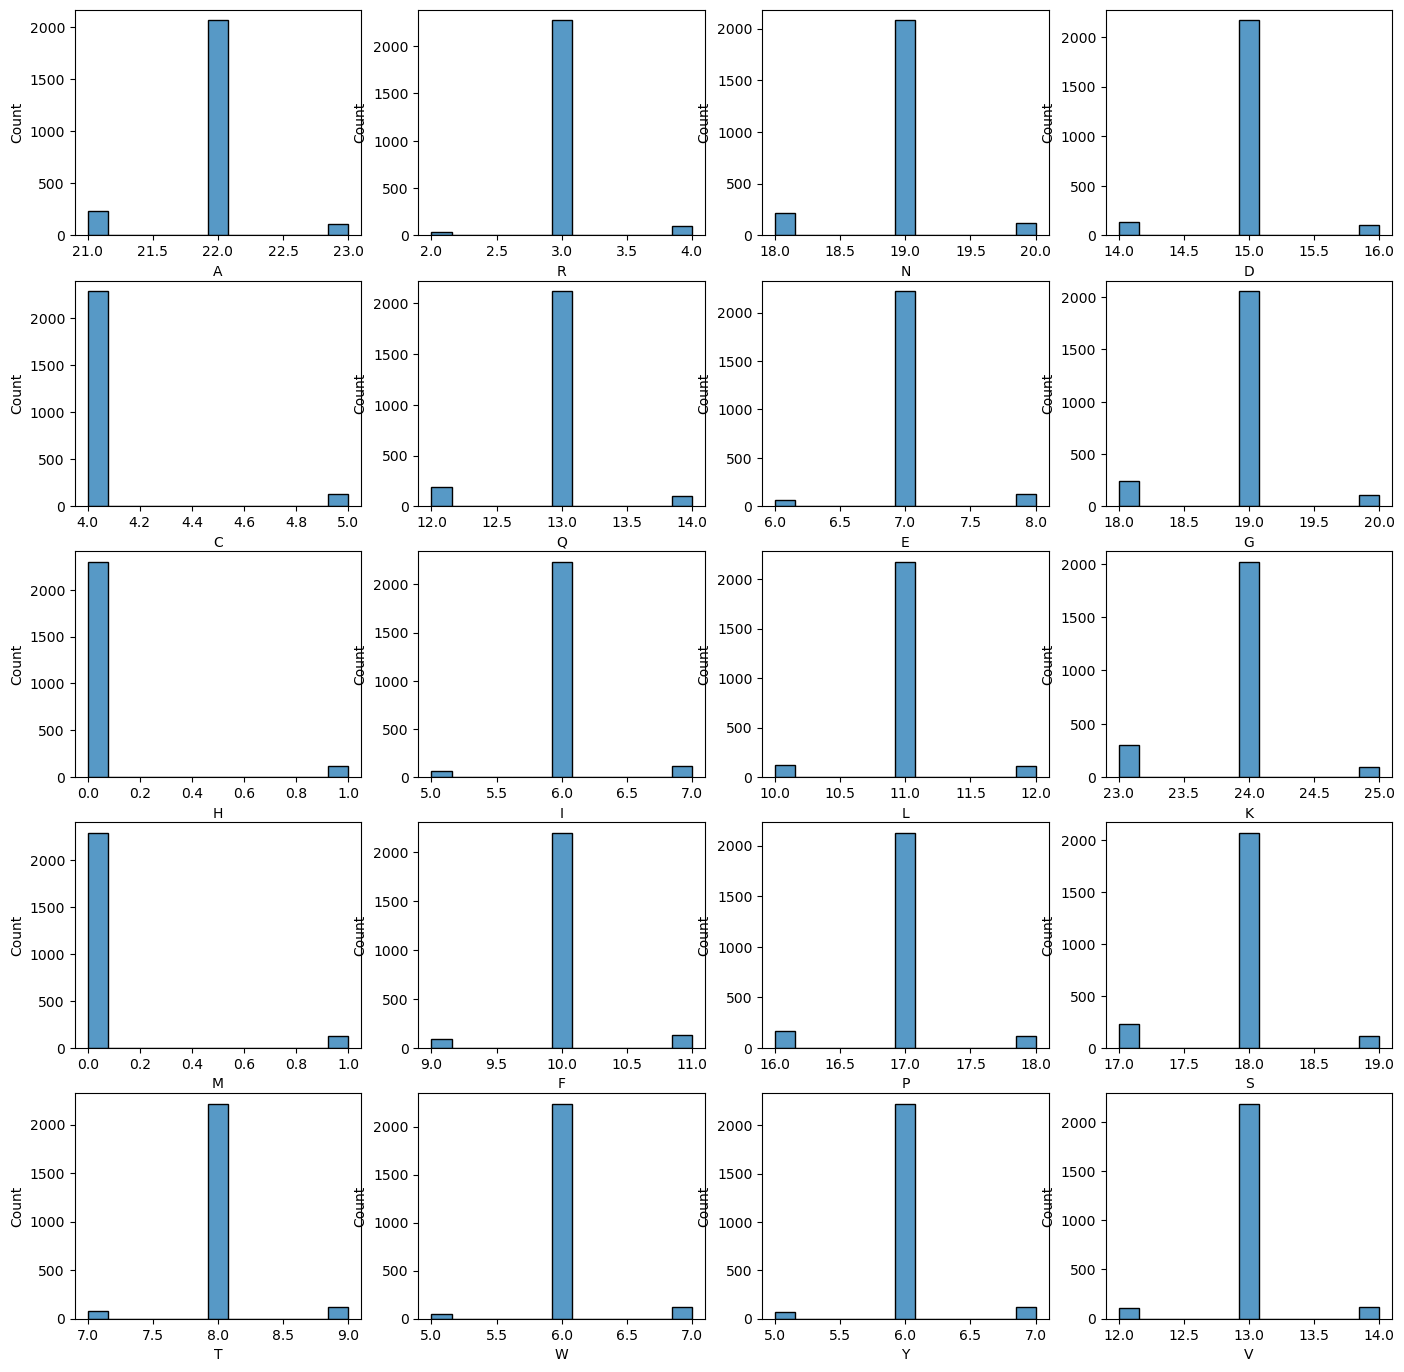

In [135]:
k=0
fig, ax = plt.subplots(5, 4, figsize= (17,17))
for i in range (0,5):
    for j in range(0,4):
        sns.histplot(test[Amino_list[k]], kde=False, ax=ax[i, j])
        #ax[i, j].set(xscale="log")
        k=k+1
